In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# %matplotlib inline is not required in scripts or Kaggle notebooks anymore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

# Seed for reproducibility
np.random.seed(123)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

# TensorFlow/Keras (use this version only for consistency)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Flatten,
    Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

#%% Load metadata
base_skin_dir = '/kaggle/input/skin-cancer-mnist-ham10000'

# Map image ids to paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}

# Map lesion codes to full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Read metadata CSV
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Add image paths and mapped lesion names
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)

# Encode class labels as integers
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

# Fill missing age values with the mean
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


/tmp/ipykernel_35/708155355.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


In [8]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

#%% Resize images
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

#%% Prepare data
features = skin_df.drop(columns=['cell_type_idx'], axis=1)
target = skin_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1234)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

# Normalize
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

# One-hot encode
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

# Validation split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1, random_state=2)

# Reshape
x_train = x_train.reshape(-1, 75, 75, 3)
x_test = x_test.reshape(-1, 75, 75, 3)
x_validate = x_validate.reshape(-1, 75, 75, 3)

/tmp/ipykernel_35/3329648744.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping


In [22]:
def inception_module(x, filters):
    conv1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3)

    conv5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    output = concatenate([conv1, conv3, conv5, pool], axis=3)
    return output

In [23]:
def build_googlenet(input_shape=(75, 75, 3), num_classes=7):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    x = AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model
model = build_googlenet(input_shape=(75, 75, 3), num_classes=7)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 38, 38, 64)     │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 19, 19, 64)     │              0 │ conv2d_66[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 19, 19, 64)     │          4,160 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 19, 19, 192)    │        110,784 │ conv2d_67[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 10, 10, 192)    │              0 │ conv2d_68[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 10, 10, 96)     │         18,528 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 10, 10, 16)     │          3,088 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 10, 10, 192)    │              0 │ max_pooling2d_17[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 10, 10, 64)     │         12,352 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 10, 10, 128)    │        110,720 │ conv2d_70[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 10, 10, 32)     │         12,832 │ conv2d_72[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 10, 10, 32)     │          6,176 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 10, 10, 256)    │              0 │ conv2d_69[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_71[0][0],       │
│                           │                        │                │ conv2d_73[0][0],       │
│                           │                        │                │ conv2d_74[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 10, 10, 128)    │         32,896 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 10, 10, 32)     │          8,224 │ concatenate_9[0][0]    │
├──────────────────────

 Total params: 6,002,231 (22.90 MB)

 Trainable params: 6,002,231 (22.90 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#%% Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)
datagen.fit(x_train)

#%% Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
#%% Training
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=10,
    validation_data=(x_validate, y_validate),
    steps_per_epoch=len(x_train) // 64,
    callbacks=[lr_reduce, early_stop],
    verbose=1
)

#%% Evaluation
loss_test, acc_test = model.evaluate(x_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(x_validate, y_validate, verbose=1)
print(f"Validation Accuracy: {acc_val:.4f}, Validation Loss: {loss_val:.4f}")
print(f"Test Accuracy: {acc_test:.4f}, Test Loss: {loss_test:.4f}")

#%% Save
model.save("GoogLeNet_HAM10000.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1747136547.618138     102 service.cc:148] XLA service 0x7972d4002e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747136547.618979     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747136547.618999     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747136549.914955     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/112 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.2422 - loss: 1.9022    

I0000 00:00:1747136568.031804     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 ━━━━━━━━━━━━━━━━━━━━ 77s 330ms/step - accuracy: 0.6426 - loss: 1.3074 - val_accuracy: 0.6808 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 2/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6250 - loss: 1.0266

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 1.0266 - val_accuracy: 0.6808 - val_loss: 0.9436 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6703 - loss: 0.9337 - val_accuracy: 0.6908 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6562 - loss: 1.1139 - val_accuracy: 0.6933 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6804 - loss: 0.8980 - val_accuracy: 0.7095 - val_loss: 0.8800 - learning_rate: 0.0010
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7031 - loss: 0.8572 - val_accuracy: 0.7032 - val_loss: 0.8690 - learning_rate: 0.0010
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.6999 - loss: 0.8513 - val_accuracy: 0.7182 - val_loss: 0.8101 - learning_rate: 0.0010
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6719 - loss: 0.8232 - val_a

In [26]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    # Accuracy
    axs[0].plot(model_history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    # Loss
    axs[1].plot(model_history.history['loss'], label='Train Loss')
    axs[1].plot(model_history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.tight_layout()
    plt.show()


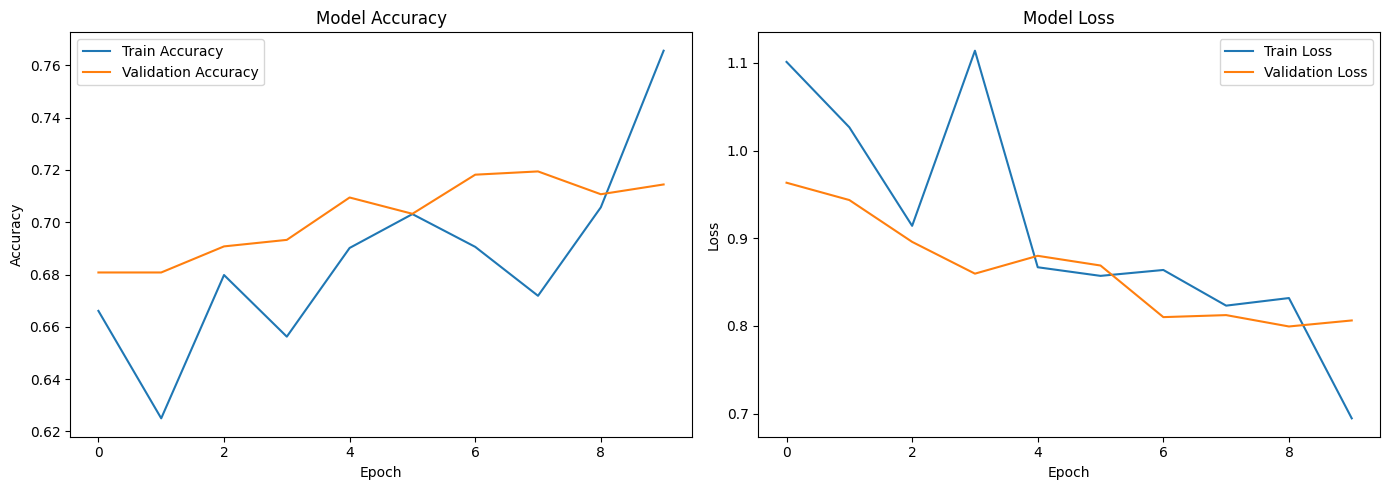

In [27]:
plot_model_history(history)

In [28]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


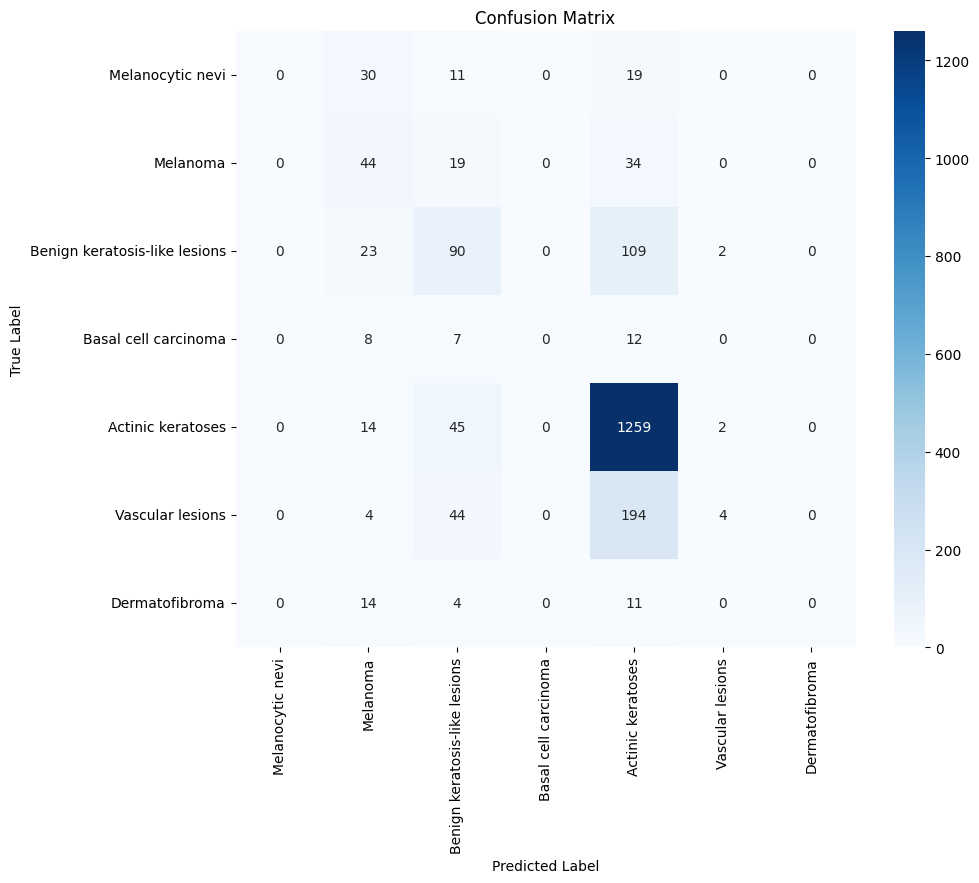

In [33]:
labels = list(lesion_type_dict.values())  # Class names in order of appearance

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, classes=labels)